In [1]:
import pandas as pd
import numpy as np
import os
import talib
import scipy.optimize as sco
from scipy.stats import norm

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from price_functions import PricesDataFrame
from utils import logreturn_to_return, return_to_logreturn, value_at_risk
import math

In [2]:
data = pd.DataFrame.from_csv('ativos_2.csv')

/home/brunocape/.virtualenvs/jordan/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


#Abrir dados

appended_data = []
date_format = '%Y-%m-%d'

for entry in os.scandir('../data_crypto/USDT'):
    if entry.is_file():
        symbol = (os.path.splitext(entry.name)[0])
        df_entry = pd.read_json(entry.path)
        df_entry = df_entry[['date','open', 'close', 'high', 'low']]
        df_entry['symbol'] = symbol
        appended_data.append(df_entry)


data = pd.concat(appended_data)
data = data.set_index('date')
data = data.pivot(columns='symbol', values='close').dropna()

In [4]:
data.describe()

,AAPL,MSFT,GOOG,TWTR,NVDA,V,NFLX,FB,AMZN,INTC,...,BAC,AMD,PEP,ATVI,C,F,AABA,BA,CSCO,WMT
count,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,...,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000
mean,167.824819,84.638750,1007.292278,24.712681,189.875363,112.779194,236.555988,163.655302,1270.626976,42.965907,...,27.117036,14.417843,111.415323,62.506573,67.804536,11.282540,62.730968,273.008831,38.027157,84.713528
std,28.376726,16.442254,128.353812,8.641600,57.798624,20.636937,88.898912,21.268510,382.296766,6.777263,...,3.270382,5.027426,5.394564,11.690231,5.856616,1.079181,11.953437,75.549500,5.980559,10.630643
min,109.110000,59.950000,759.110000,14.290000,89.590000,77.110000,119.160000,115.050000,749.870000,33.460000,...,21.840000,8.680000,96.160000,36.110000,55.680000,8.180000,38.410000,152.160000,29.330000,65.660000
25%,146.942500,69.447500,922.842500,17.287500,144.172500,94.130000,156.432500,149.795000,957.992500,36.260000,...,23.877500,11.395000,108.680000,56.567500,62.040000,10.787500,50.650000,187.982500,32.187500,76.017500
50%,167.170000,84.115000,1021.045000,21.115000,197.630000,111.975000,195.525000,167.915000,1157.975000,44.395000,...,27.445000,12.865000,112.165000,64.285000,68.435000,11.295000,66.520000,268.645000,37.305000,85.185000
75%,186.342500,98.367500,1104.167500,31.852500,242.705000,131.127500,321.772500,178.920000,1600.490000,48.370000,...,30.132500,14.670000,115.510000,71.080000,72.380000,12.137500,72.107500,344.682500,43.750000,94.180000
max,232.070000,115.610000,1268.330000,46.760000,289.360000,150.790000,418.970000,217.500000,2039.510000,57.080000,...,32.840000,32.720000,121.760000,83.390000,80.080000,13.230000,82.360000,392.300000,49.140000,109.550000


In [6]:
data

,AAPL,MSFT,GOOG,TWTR,NVDA,V,NFLX,FB,AMZN,INTC,...,BAC,AMD,PEP,ATVI,C,F,AABA,BA,CSCO,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-12,109.11,60.22,762.52,18.23,91.88,77.31,119.16,117.43,759.36,34.39,...,21.84,8.68,100.71,36.48,57.28,12.44,40.20,152.16,29.53,69.94
2016-06-12,109.95,59.95,759.11,18.23,93.39,77.11,124.57,117.31,764.72,34.72,...,22.16,9.45,101.55,36.70,57.92,12.56,39.97,152.24,29.33,70.36
2016-07-12,111.03,61.37,771.19,19.48,95.07,79.31,125.39,117.95,770.42,35.50,...,22.57,9.56,102.81,37.45,59.06,13.06,40.52,154.14,29.95,70.60
2016-08-12,112.12,61.01,776.42,19.64,93.48,79.28,123.24,118.91,767.33,35.70,...,22.95,10.34,102.15,37.39,60.15,13.03,41.41,155.39,29.95,70.34
2016-09-12,113.95,61.97,789.29,19.65,91.82,79.14,122.88,119.68,768.66,35.76,...,23.09,10.34,103.57,36.79,60.04,13.17,41.76,156.49,30.06,70.08
2016-12-12,113.30,62.17,789.27,18.93,89.59,78.50,122.83,117.77,760.12,35.97,...,22.61,10.68,104.72,37.17,59.55,12.82,41.30,157.16,30.17,71.67
2016-12-13,115.19,62.98,796.10,19.37,91.17,79.20,123.78,120.31,774.34,36.80,...,22.61,10.54,105.63,37.32,59.79,12.77,41.47,156.66,30.59,71.80
2016-12-14,115.19,62.68,797.07,18.93,96.45,79.13,123.44,120.21,768.82,36.55,...,22.67,10.55,104.47,36.74,59.45,12.53,40.91,154.47,30.46,71.34
2016-12-15,115.82,62.58,797.85,18.79,98.71,79.50,125.00,120.57,761.00,36.79,...,23.16,10.86,105.30,36.99,60.23,12.58,38.41,153.77,30.63,71.08


In [7]:
TAMANHO_TREINO = 0.5
qt_dados_treinamento = int(round((len(data)*TAMANHO_TREINO), 0))
df_prices = PricesDataFrame(data[:qt_dados_treinamento]) 
df_prices_test = PricesDataFrame(data[qt_dados_treinamento:])
df_prices_all = PricesDataFrame(data)

/home/brunocape/Projects/pyfinance/pynance/price_functions.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  prices.sort_index(inplace=True)


In [8]:
df_prices.prices

,AAPL,MSFT,GOOG,TWTR,NVDA,V,NFLX,FB,AMZN,INTC,...,BAC,AMD,PEP,ATVI,C,F,AABA,BA,CSCO,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-12,109.11,60.22,762.52,18.23,91.88,77.31,119.16,117.43,759.36,34.39,...,21.84,8.68,100.71,36.48,57.28,12.44,40.20,152.16,29.53,69.94
2016-06-12,109.95,59.95,759.11,18.23,93.39,77.11,124.57,117.31,764.72,34.72,...,22.16,9.45,101.55,36.70,57.92,12.56,39.97,152.24,29.33,70.36
2016-07-12,111.03,61.37,771.19,19.48,95.07,79.31,125.39,117.95,770.42,35.50,...,22.57,9.56,102.81,37.45,59.06,13.06,40.52,154.14,29.95,70.60
2016-08-12,112.12,61.01,776.42,19.64,93.48,79.28,123.24,118.91,767.33,35.70,...,22.95,10.34,102.15,37.39,60.15,13.03,41.41,155.39,29.95,70.34
2016-09-12,113.95,61.97,789.29,19.65,91.82,79.14,122.88,119.68,768.66,35.76,...,23.09,10.34,103.57,36.79,60.04,13.17,41.76,156.49,30.06,70.08
2016-12-12,113.30,62.17,789.27,18.93,89.59,78.50,122.83,117.77,760.12,35.97,...,22.61,10.68,104.72,37.17,59.55,12.82,41.30,157.16,30.17,71.67
2016-12-13,115.19,62.98,796.10,19.37,91.17,79.20,123.78,120.31,774.34,36.80,...,22.61,10.54,105.63,37.32,59.79,12.77,41.47,156.66,30.59,71.80
2016-12-14,115.19,62.68,797.07,18.93,96.45,79.13,123.44,120.21,768.82,36.55,...,22.67,10.55,104.47,36.74,59.45,12.53,40.91,154.47,30.46,71.34
2016-12-15,115.82,62.58,797.85,18.79,98.71,79.50,125.00,120.57,761.00,36.79,...,23.16,10.86,105.30,36.99,60.23,12.58,38.41,153.77,30.63,71.08


In [9]:
df_returns = df_prices.returns()

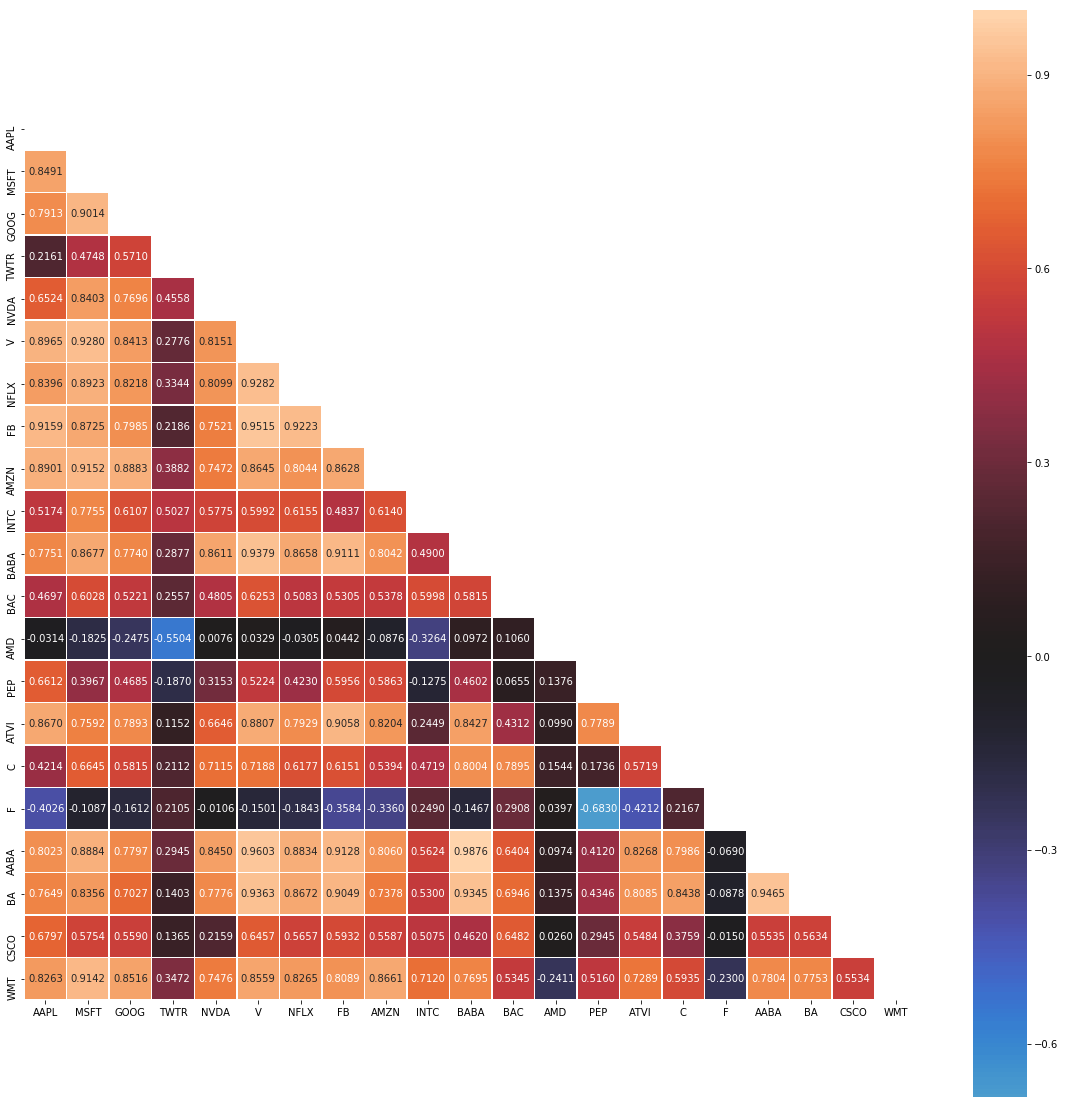

In [10]:
corr = df_prices.correlation()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5)

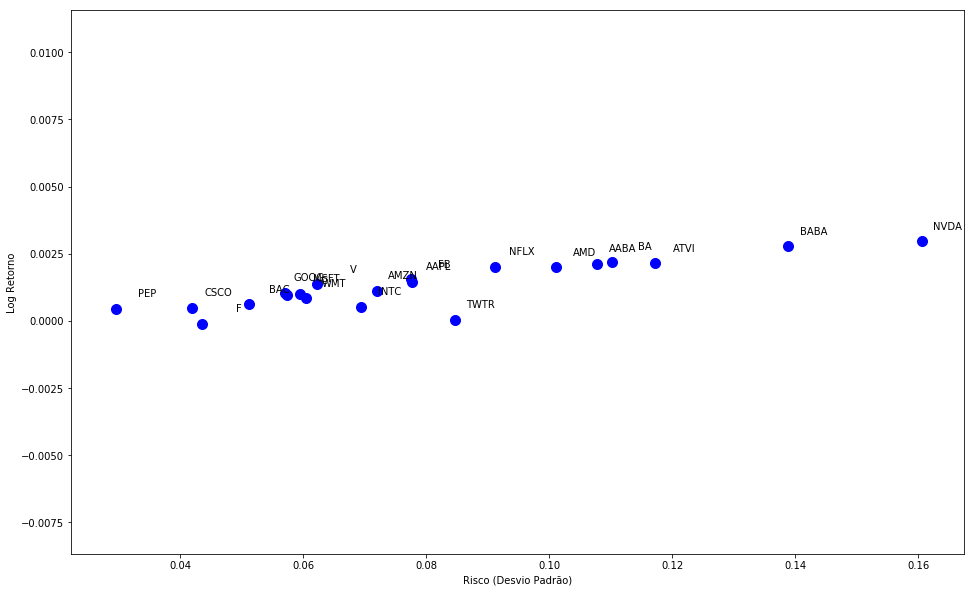

In [11]:
fig= plt.figure(figsize=(16,10))
for asset in df_prices.mean_returns().index:
    plt.scatter(df_prices.variance().loc[asset], df_prices.mean_returns().loc[asset],marker='o',color='b',s=100, label=asset)
    plt.annotate(asset,
             xy=(df_prices.variance().loc[asset], df_prices.mean_returns().loc[asset]),
             xytext=(40, 10),
             textcoords='offset points',
             ha='right',
             va='bottom')
plt.ylabel('Log Retorno')
plt.xlabel('Risco (Desvio Padrão)')


plt.show()

In [12]:
vars_result = {}
for symbol in df_prices.mean_returns().index:
    var = value_at_risk(0.95, df_prices.mean_returns().loc[symbol], df_prices.variance().loc[symbol], 1)
    vars_result[symbol] = var
    
    print(f'Value at risk {symbol}: {var}')
vars_result = pd.DataFrame.from_dict(vars_result,  orient='index')

Value at risk AAPL: -0.11860551608545311
Value at risk MSFT: -0.09231711180209112
Value at risk GOOG: -0.08859303599645374
Value at risk TWTR: -0.12992763030035603
Value at risk NVDA: -0.22995990513108944
Value at risk V: -0.09611805728568479
Value at risk NFLX: -0.13750986162680567
Value at risk FB: -0.1182737280967181
Value at risk AMZN: -0.1107976026839137
Value at risk INTC: -0.10750074635722306
Value at risk BABA: -0.20189658475400607
Value at risk BAC: -0.08027589167077775
Value at risk AMD: -0.15153110793944957
Value at risk PEP: -0.04709565570659635
Value at risk ATVI: -0.17360268425670178
Value at risk C: -0.08928598004930377
Value at risk F: -0.06926064954227884
Value at risk AABA: -0.16062911606781283
Value at risk BA: -0.16390198828604063
Value at risk CSCO: -0.06628120440427909
Value at risk WMT: -0.09386005353076421


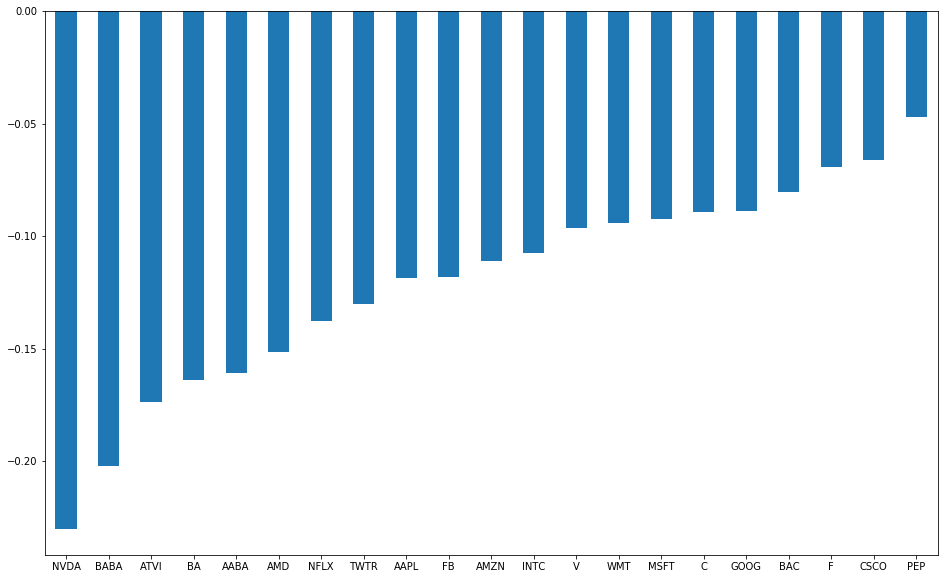

In [13]:
vars_result.sort_values(by=0).plot.bar(rot=0, figsize=(16,10),legend=False )

In [14]:
rf = return_to_logreturn(0.0019)

In [15]:
rf

0.0018981972830802655

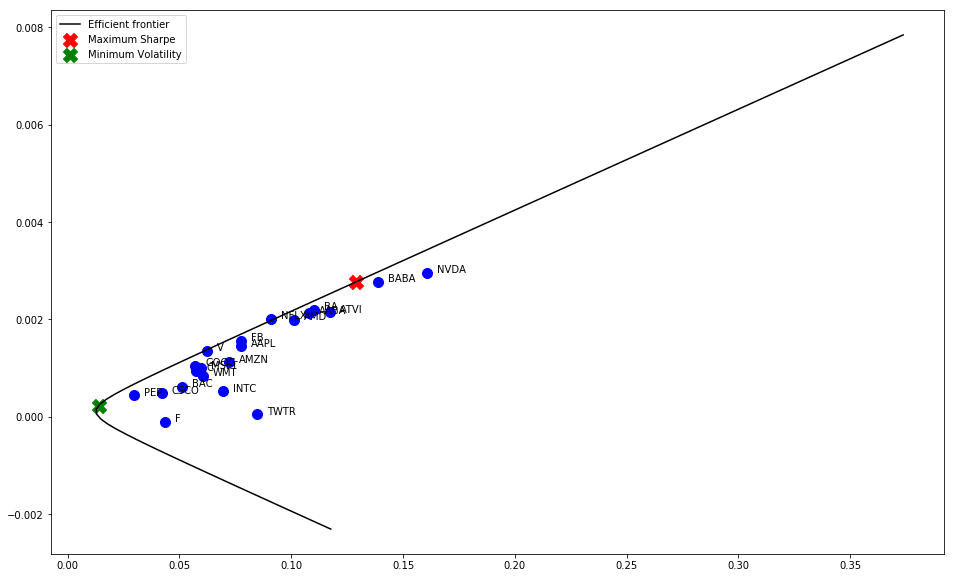

In [16]:
df_prices.plot_efficient_frontier(rf, use_negative=False)

In [17]:
ef = df_prices.efficient_frontier(rf, use_negative=True)
ef_without_negative = df_prices.efficient_frontier(rf, use_negative=False)

In [18]:
pmv_without_negative = df_prices.min_volatility(use_negative=False)
pt_without_negative = df_prices.max_sharpe(rf,use_negative=False)

In [19]:
pmv = df_prices.min_volatility()
pt = df_prices.max_sharpe(rf)

In [20]:
var = value_at_risk(0.95, pmv['portfolio_return'], pmv['portfolio_volatility'], 100)
print(f'Value at risk PMV: {var}')
var = value_at_risk(0.95, pt['portfolio_return'], pt['portfolio_volatility'], 100)
print(f'Value at risk PT: {var}')

Value at risk PMV: -1.172938796621248
Value at risk PT: -54.08247326257425


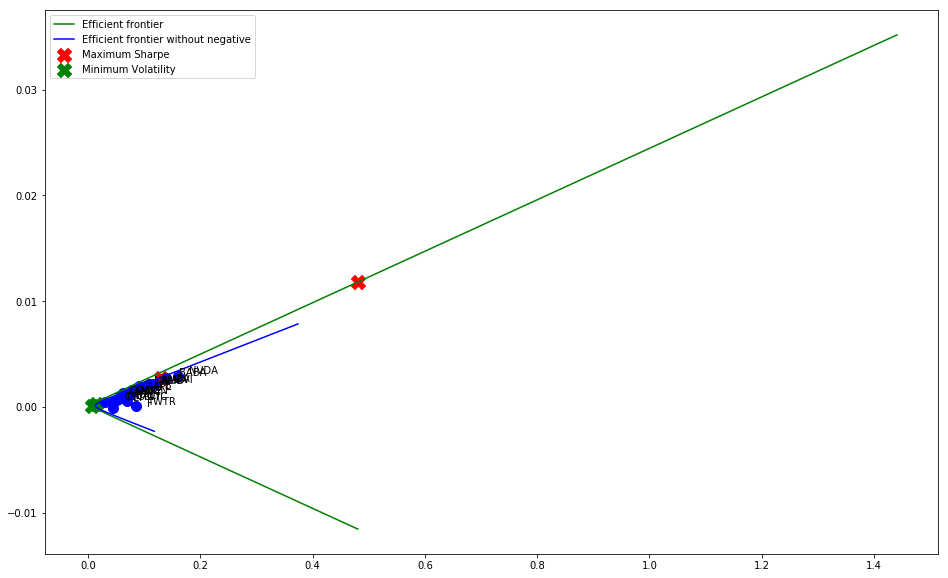

In [21]:
fig= plt.figure(figsize=(16,10))
plt.plot( 'portfolio_volatility', 'portfolio_return', data=ef, color='green')
plt.scatter(pt['portfolio_volatility'], pt['portfolio_return'], marker='X',color='r',s=200, label='Maximum Sharpe')
plt.scatter(pmv['portfolio_volatility'], pmv['portfolio_return'],marker='X',color='g',s=200, label='Minimum Volatility')
plt.plot( 'portfolio_volatility', 'portfolio_return', data=ef_without_negative, color='blue')
plt.scatter(pt_without_negative['portfolio_volatility'], pt_without_negative['portfolio_return'], marker='X',color='r',s=200, label='Maximum Sharpe')
plt.scatter(pmv_without_negative['portfolio_volatility'], pmv_without_negative['portfolio_return'],marker='X',color='g',s=200, label='Minimum Volatility')

for asset in df_prices.mean_returns().index:
    plt.scatter(df_prices.variance().loc[asset], df_prices.mean_returns().loc[asset],marker='o',color='b',s=100, label=asset)
    plt.annotate(asset,
             xy=(df_prices.variance().loc[asset], df_prices.mean_returns().loc[asset]),
             xytext=(40, 0),
             textcoords='offset points',
             ha='right',
             va='bottom')

plt.legend(['Efficient frontier','Efficient frontier without negative', 'Maximum Sharpe', 'Minimum Volatility'])
plt.show()

In [22]:
weights_pmv = pmv['weights']
weights_pt = pt['weights']
weights_pmv_without_negative = pmv_without_negative['weights']
weights_pt_without_negative = pt_without_negative['weights']

In [23]:
return_pmv = logreturn_to_return(df_prices_test.portfolio_return_for_all_period(weights_pmv))
return_pt = logreturn_to_return(df_prices_test.portfolio_return_for_all_period(weights_pt))
return_pmv_without_negative = logreturn_to_return(df_prices_test.portfolio_return_for_all_period(weights_pmv_without_negative))
return_pt_without_negative = logreturn_to_return(df_prices_test.portfolio_return_for_all_period(weights_pt_without_negative))

print(f'Retorno PMV: {return_pmv_without_negative}')
print(f'Retorno PT: {return_pt_without_negative}')

print('Com negativos')
print(f'Retorno PMV: {return_pmv}')
print(f'Retorno PT: {return_pt}')

Retorno PMV: -0.08794246489779867
Retorno PT: -0.025146864687689674
Com negativos
Retorno PMV: -0.19763454310239015
Retorno PT: 0.7487464708528537


In [26]:
weights_BTC = weights_pmv_without_negative * 0
weights_BTC.loc['PEP'] = 1

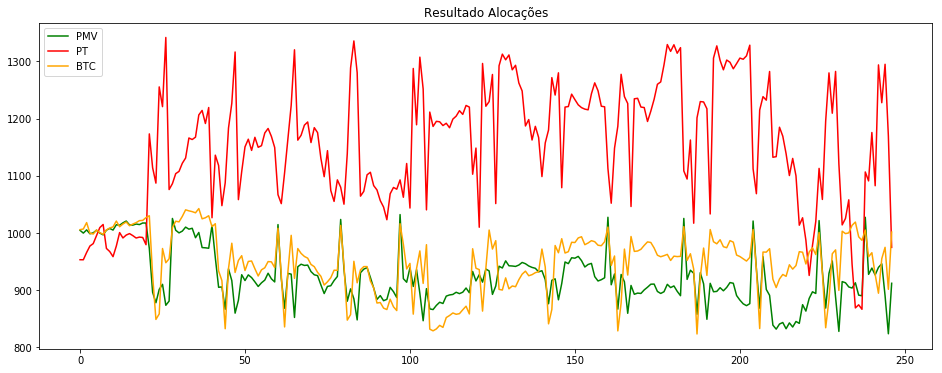

In [27]:
return_pmv = df_prices_test.portfolio_value_for_row(weights_pmv_without_negative, 1000)
return_pt = df_prices_test.portfolio_value_for_row(weights_pt_without_negative, 1000)
return_btc = df_prices_test.portfolio_value_for_row(weights_BTC, 1000)
portfolio_result = pd.concat([return_pmv, return_pt, return_btc], axis=1, join_axes=[return_pt.index])
portfolio_result.columns=['return_pmv','return_pt','return_btc']
portfolio_result = PricesDataFrame(portfolio_result)
fig= plt.figure(figsize=(16,6))
plt.title('Resultado Alocações')
plt.plot('portfolio_return', data=return_pmv.reset_index(), color='green')
plt.plot('portfolio_return', data=return_pt.reset_index(), color='red')
plt.plot('portfolio_return', data=return_btc.reset_index(), color='orange')
plt.legend(['PMV', 'PT', 'BTC'])

In [28]:
portfolio_result.variance()

,variance
return_pmv,0.044166
return_pt,0.072610
return_btc,0.047629


In [29]:
portfolio_result.sharpe(rf)

,sharpe
return_pmv,-0.051873
return_pt,-0.024887
return_btc,-0.040210


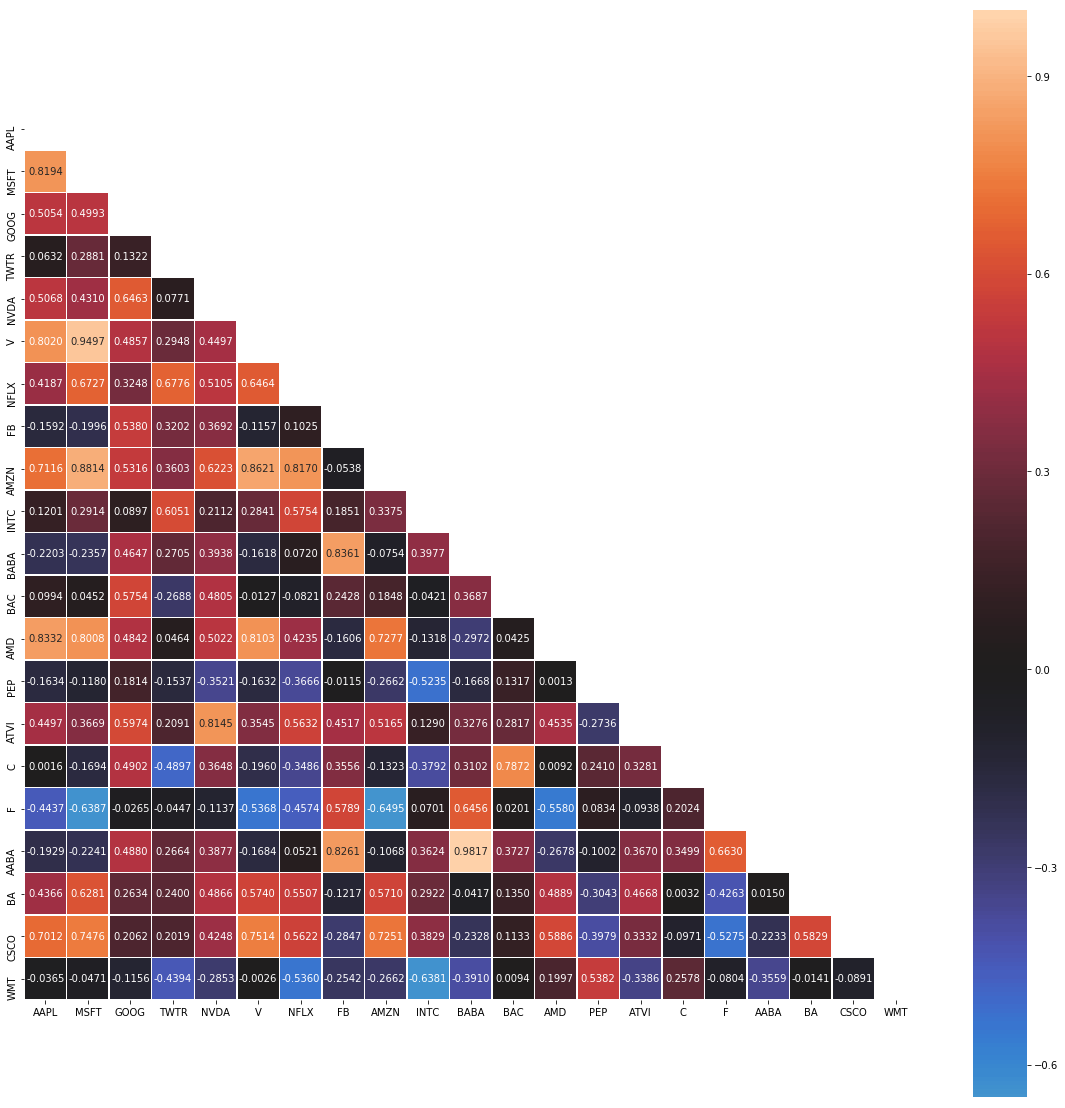

In [30]:
#Mudança de cenário 2018

corr = df_prices_test.correlation()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5)

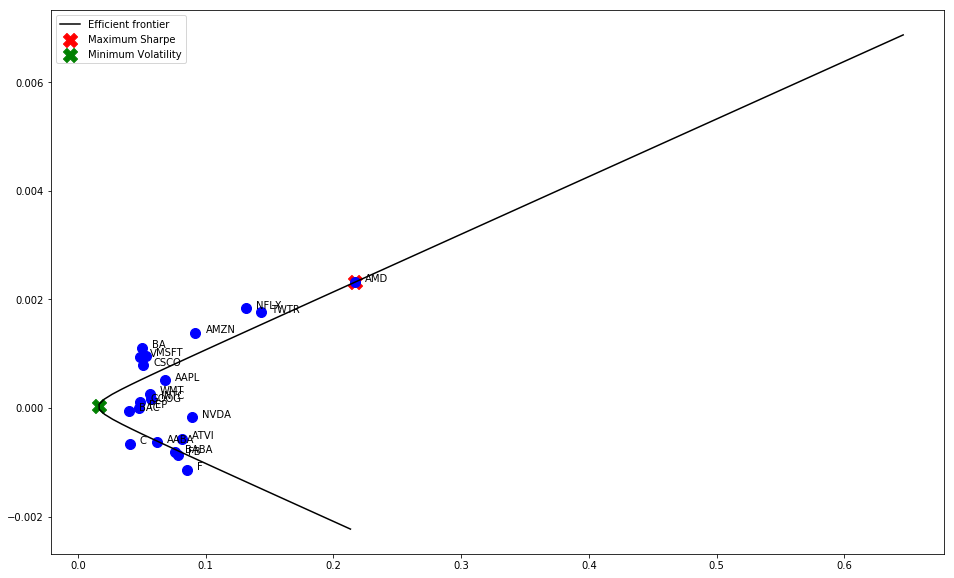

In [31]:
df_prices_test.plot_efficient_frontier(rf, use_negative=False)

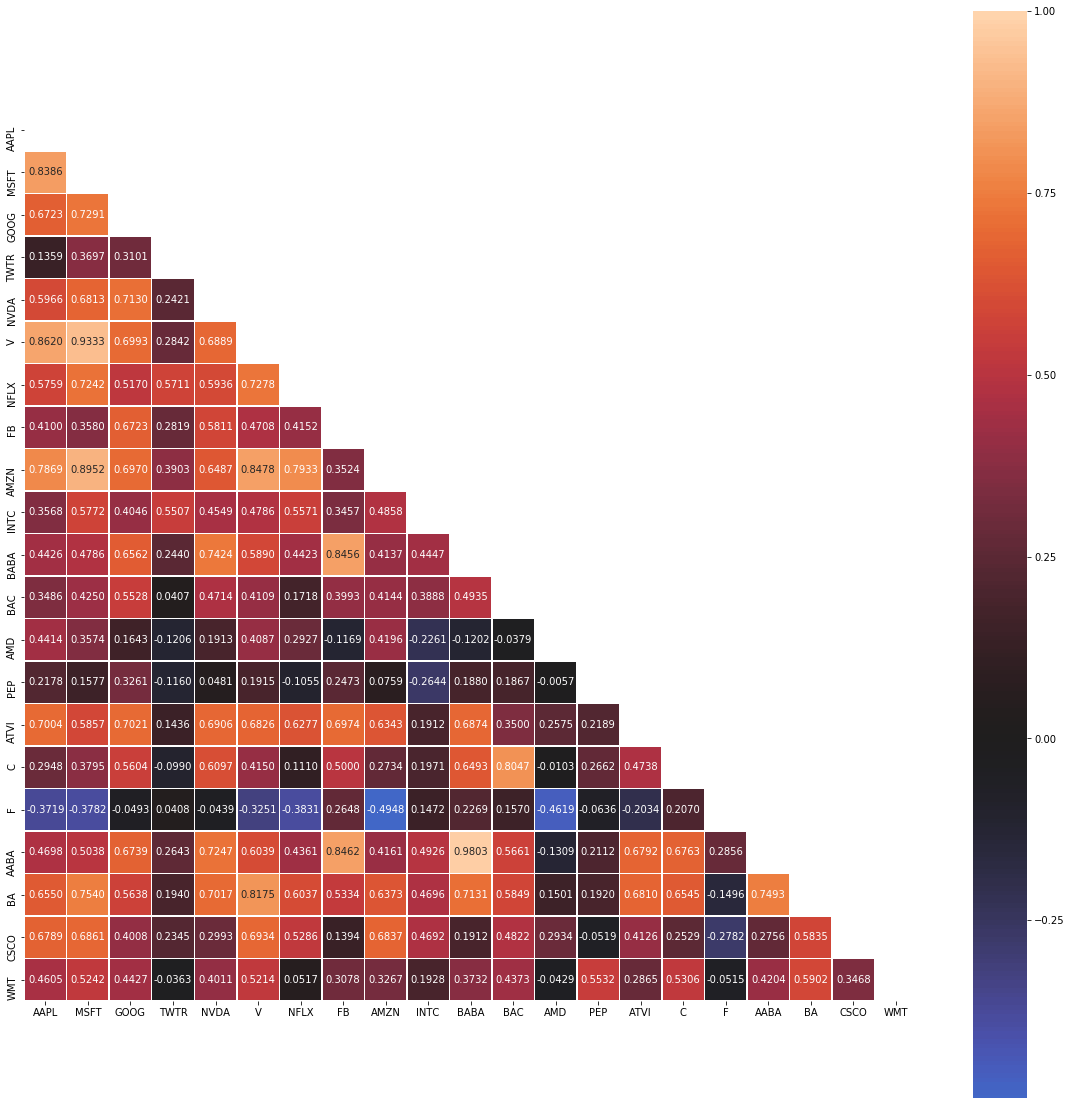

In [32]:
corr = df_prices_all.correlation()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5)

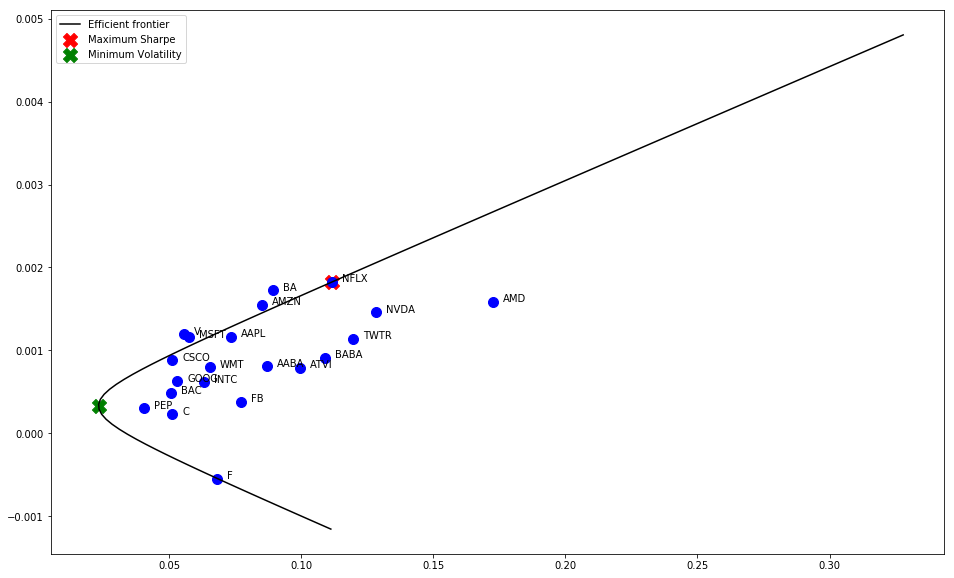

In [33]:
df_prices_all.plot_efficient_frontier(rf, use_negative=False)